In [528]:
import pandas as pd
import numpy as np
import re
import warnings
import calendar
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline

In [529]:
df = pd.read_csv('abc.csv',parse_dates=['Date'])

In [531]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12554 entries, 0 to 12553
Data columns (total 9 columns):
Date               12554 non-null datetime64[ns]
Client             12554 non-null object
Project            12554 non-null object
Project Manager    12554 non-null object
Task               12554 non-null object
Hours              12554 non-null float64
Billable?          12554 non-null object
Invoiced?          12554 non-null object
Month-Year         12554 non-null object
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 882.8+ KB


In [532]:
df.Date.describe()               

count                   12554
unique                    873
top       2015-01-04 00:00:00
freq                       35
first     2014-01-01 00:00:00
last      2016-12-31 00:00:00
Name: Date, dtype: object

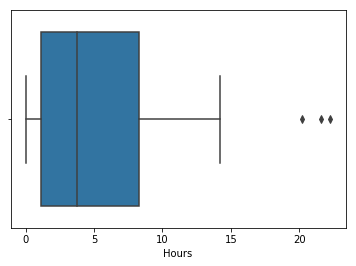

In [533]:
sns.boxplot('Hours',data=df)

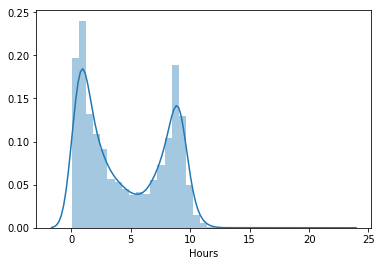

In [534]:
sns.distplot(df['Hours'])

In [535]:
df=df[df['Hours']<17]

In [536]:
Agg_df = df.copy()

In [537]:
df['month']= df['Date'].dt.month
df['Year']= df['Date'].dt.year
df['week']= df['Date'].dt.weekofyear
df['weekday']= df['Date'].dt.weekday

In [646]:
#df.groupby('Task').Hours.mean().plot(kind='bar')

In [647]:
#df.Task.value_counts()

In [540]:
none_bill =  ['4. Sick','3. Half Day Off' ,'2. Full Day Off']

In [541]:
df=df[~df['Task'].isin(none_bill)]

In [542]:
df_task=df.groupby(['Task']).Hours.mean().reset_index().rename({'Hours':'Avg_Task_Hr'},axis=1)

In [543]:
df=pd.merge(df,df_task,left_on='Task',right_on='Task',how='left')

In [544]:
df_U_Project=df.groupby(['Client']).agg({'Project': lambda x: x.nunique()}).rename({'Project':'Dist_Project'},axis=1)

In [545]:
df=pd.merge(df,df_U_Project,left_on='Client',right_on='Client',how='left')

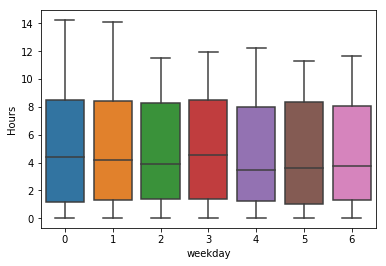

In [546]:
sns.boxplot(x='weekday',y='Hours',data=df)

In [547]:
df_weekday=df.groupby(['weekday']).agg({'Hours': 'mean'}).rename({'Hours':'Weekly_Hrs'},axis=1)

In [548]:
df=pd.merge(df,df_weekday,left_on='weekday',right_on='weekday',how='left')

In [549]:
df_client=df.groupby(['Client','Task']).agg({'Hours':'mean'}).rename({'Hours' : 'Avg_client_Hr'},axis=1).reset_index()

In [550]:
df=pd.merge(df,df_client,left_on=['Client','Task'],right_on=['Client','Task'],how='left')

In [551]:
df_Total=df.groupby(['Client','Task']).agg({'Hours':'sum'}).rename({'Hours' : 'TotHrs'},axis=1).reset_index()

In [552]:
df=pd.merge(df,df_Total,left_on=['Client','Task'],right_on=['Client','Task'],how='left')

In [553]:
df['Proj_avg_hrs']=df.TotHrs/df.Dist_Project

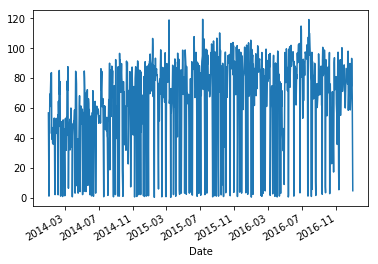

In [555]:
df.groupby('Date').Hours.sum().plot(kind='line')

In [556]:
df['MonthYear']=df['Date'].dt.to_period('M')

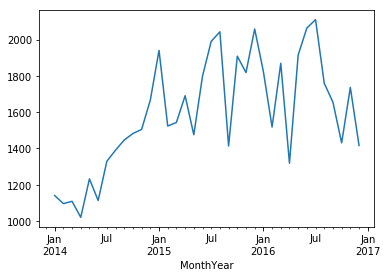

In [557]:
df.groupby('MonthYear').Hours.sum().plot(kind='line')

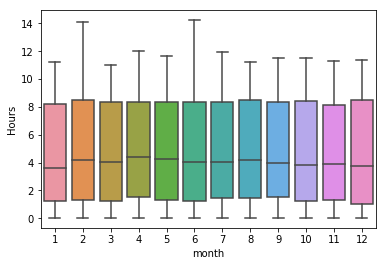

In [558]:
sns.boxplot(x='month',y='Hours',data=df)

In [559]:
df['WeekYear']=df['Date'].dt.to_period('W')

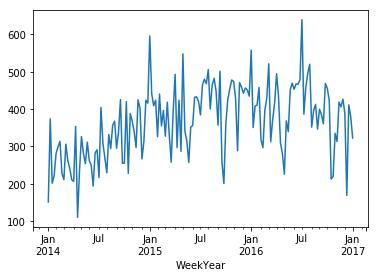

In [560]:
df.groupby('WeekYear').Hours.sum().plot(kind='line')

In [561]:
df=df.drop(['Project','Project Manager','Invoiced?','Month-Year'],axis=1)

In [562]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Client_1']=le.fit_transform(df.Client)

In [563]:
df=df.drop('Client',axis=1)

In [564]:
df['Billable?']=df['Billable?'].map({'Yes' : 1, 'No' : 0})

In [565]:
df=df.drop(['WeekYear','MonthYear'],axis=1)

In [566]:
df=pd.get_dummies(df)

In [567]:
train=df[df['Date']<'2016-11-30']

In [568]:
test=df[df['Date']>'2016-11-30']

In [569]:
train.shape,test.shape

((11782, 31), (322, 31))

In [648]:
'''
fig = plt.subplots(figsize = (15, 15))
sns.heatmap(train.corr())
'''

'\nfig = plt.subplots(figsize = (15, 15))\nsns.heatmap(train.corr())\n'

### Models

In [572]:
x_train=train.drop(['Hours','Date'],axis=1)
y_train=train.Hours
x_test=test.drop(['Hours','Date'],axis=1)
y_test=test.Hours
x_train.shape,y_train.shape, x_test.shape,y_test.shape

((11782, 29), (11782,), (322, 29), (322,))

### Regression

In [573]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()
from sklearn.metrics import mean_squared_error

regr.fit(x_train,y_train)

pred_train = regr.predict(x_train)
pred_test = regr.predict(x_test)

In [574]:
print(np.sqrt(mean_squared_error(y_train, pred_train)))

2.9202725088697603


In [575]:
print(np.sqrt(mean_squared_error(y_test, pred_test)))

2.7143165894445875


In [576]:
plot_data = x_test[['week']]
plot_data['Actual'] = y_test
plot_data['Predicted'] = pred_test

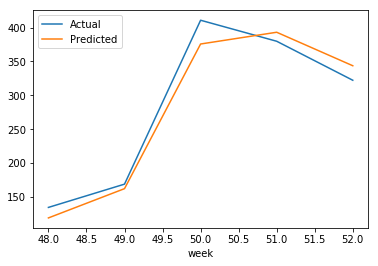

In [577]:
plot_data.groupby('week').agg({'Actual':sum , 'Predicted' : sum}).plot(kind='line')

### Lasso

In [578]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
lasso = LassoCV(alphas=[0.0001,0.001,0.01,0.1,1,10],cv=10,random_state = 1).fit(x_train,y_train)

In [579]:
lasso.alpha_

0.1

In [580]:
pred_train2 = lasso.predict(x_train)
pred_test2 = lasso.predict(x_test)

In [581]:
print(np.sqrt(mean_squared_error(y_train, pred_train2)))

2.9238806792136063


In [582]:
print(np.sqrt(mean_squared_error(y_test, pred_test2)))

2.716999908921396


In [583]:
plot_data = x_test[['week']]
plot_data['Actual'] = y_test
plot_data['Predicted'] = pred_test2

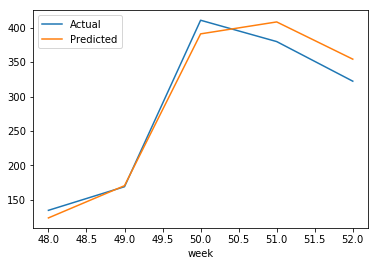

In [584]:
plot_data.groupby('week').agg({'Actual':sum , 'Predicted' : sum}).plot(kind='line')

### Xgboost

In [585]:
import xgboost as xgb

xgreg = xgb.XGBRegressor(
                 colsample_bytree=1,
                 gamma=1,
                 learning_rate=0.01,
                 max_depth=10,
                 n_estimators=1000,                                                                  
                 reg_alpha=0.1,
                 subsample=1,
                 seed=42,
                 silent=1)

xgreg.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=42, silent=1,
       subsample=1)

In [586]:
pred_train1 = xgreg.predict(x_train)
pred_test1 = xgreg.predict(x_test)

In [587]:
print(np.sqrt(mean_squared_error(y_train, pred_train1)))

1.9037434364828494


In [588]:
print(np.sqrt(mean_squared_error(y_test, pred_test1)))

2.974839577247236


In [589]:
plot_data = x_test[['week']]
plot_data['Actual'] = y_test
plot_data['Predicted'] = pred_test1

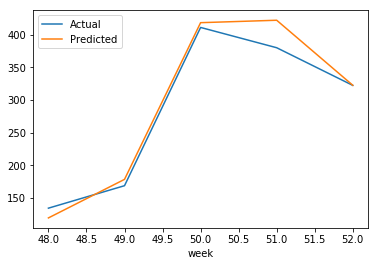

In [590]:
plot_data.groupby('week').agg({'Actual':sum , 'Predicted' : sum}).plot(kind='line')

In [649]:
#xgb.plot_importance(xgreg, max_num_features=50, height=0.5)

### Time Serier Analysis

In [592]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m-%Y')
data = pd.read_csv('Datamind.csv', parse_dates=['Month-Year'],date_parser=dateparse)         

In [593]:
ts=data.groupby('Month-Year').Hours.sum().reset_index()

In [594]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
Month-Year    36 non-null datetime64[ns]
Hours         36 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 656.0 bytes


In [595]:
ts=ts.set_index('Month-Year')

In [596]:
ts.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01'],
              dtype='datetime64[ns]', name='Month-Year', freq=None)

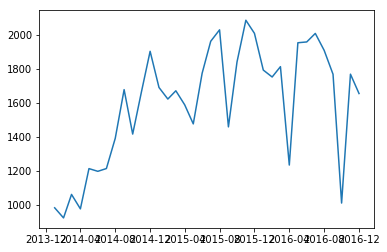

In [597]:
plt.plot(ts)

In [621]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.subplots(figsize = (15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

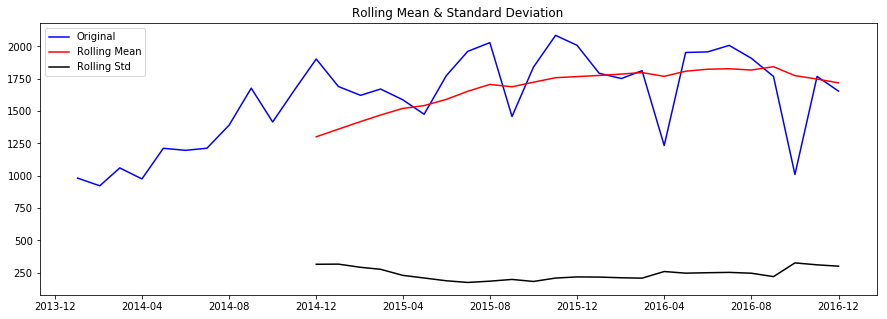

In [622]:
test_stationarity(ts)

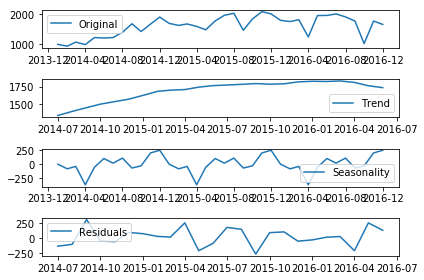

In [626]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

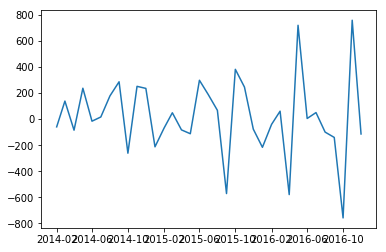

In [632]:
ts_diff = ts - ts.shift()

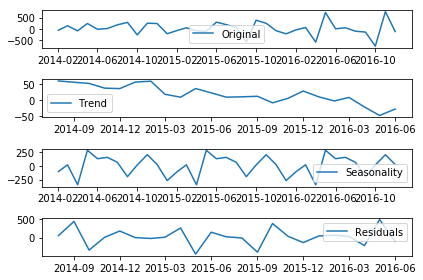

In [639]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

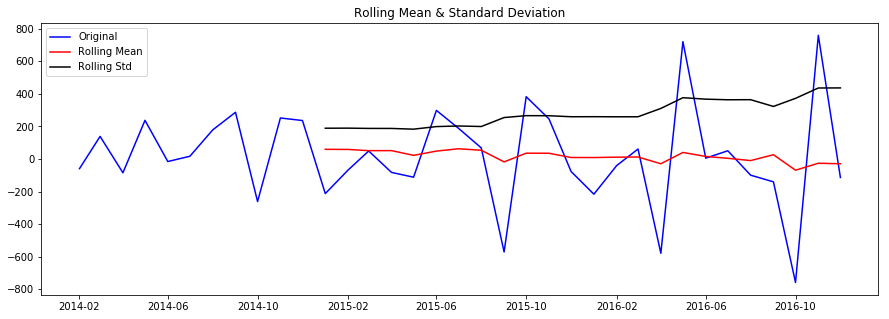

In [634]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

In [635]:
from statsmodels.tsa.stattools import acf, pacf

In [636]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

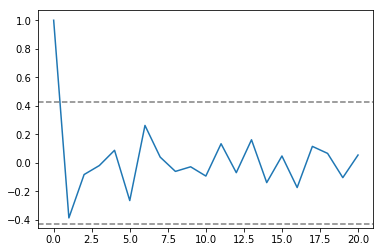

In [641]:
plt.plot(lag_acf)
plt.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')

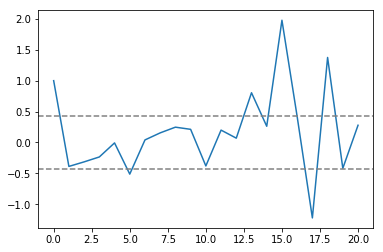

In [640]:
plt.plot(lag_pacf)
plt.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')

In [642]:
from statsmodels.tsa.arima_model import ARIMA

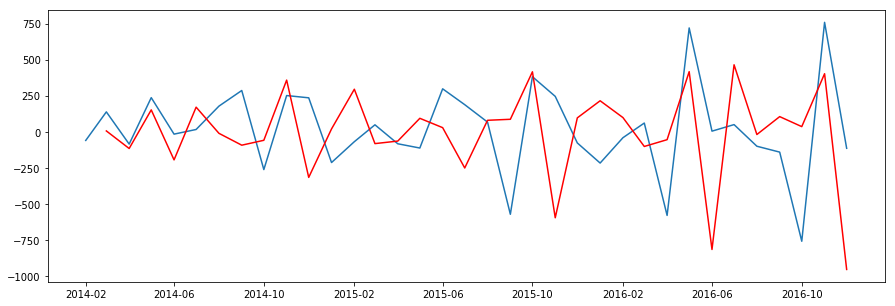

In [645]:
fig = plt.subplots(figsize = (15, 5))
model = ARIMA(ts_diff, order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

### Customer Segmentation 

In [337]:
custData = Agg_df.groupby('Client').agg({'Hours': 'sum', 'Billable?': {'Yes':lambda x: sum(x=='Yes'),'No':lambda x: sum(x=='No')}, \
                           'Project': {'Unique Projects':lambda x: x.nunique()}, \
                           'Date': {'Last Visit':lambda x: x.max(),'Frequency':lambda x: len(x), 'First Visit':\
                           lambda x: x.min()}})

In [338]:
custData.columns = [' '.join(col).strip() for col in custData.columns.values]

In [339]:
custData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, Customer 1 to Customer 97
Data columns (total 7 columns):
Hours sum                  97 non-null float64
Billable? Yes              97 non-null int64
Billable? No               97 non-null int64
Project Unique Projects    97 non-null int64
Date Last Visit            97 non-null datetime64[ns]
Date Frequency             97 non-null int64
Date First Visit           97 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4)
memory usage: 6.1+ KB


In [340]:
custData['Date Last Visit'] = custData['Date Last Visit'].astype('datetime64[ns]')

In [341]:
custData['Date First Visit'] = custData['Date First Visit'].astype('datetime64[ns]')

In [342]:
custData['Duration'] = (custData['Date Last Visit'] - custData['Date First Visit']).dt.days

In [343]:
custData = custData.reset_index()

In [344]:
clusterData = custData.drop(['Date Last Visit', 'Date First Visit'], axis=1)

In [345]:
X= clusterData.drop('Client', axis=1)

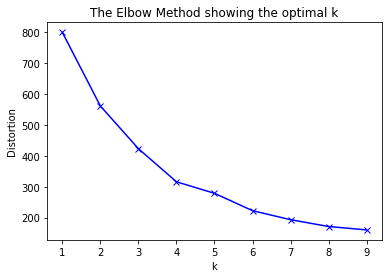

In [346]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [350]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

In [351]:
clusterData['Cluster Label'] = kmeans.labels_

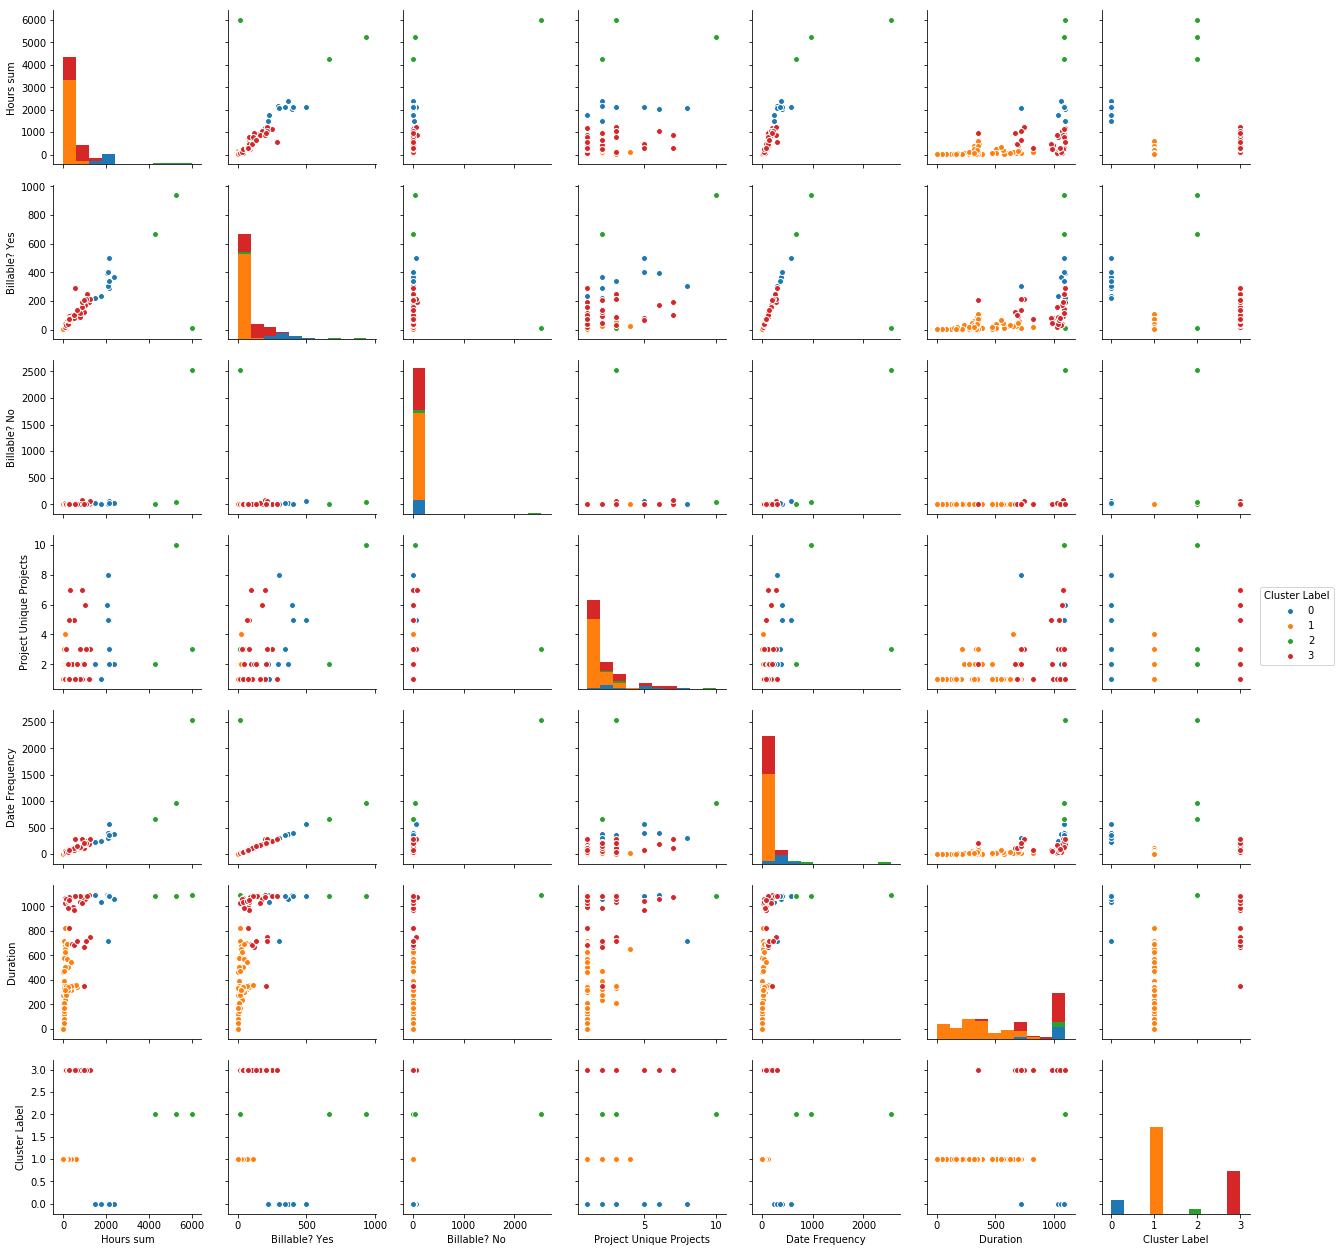

In [352]:
g = sns.pairplot(clusterData.drop('Client', axis=1), hue='Cluster Label')